<a href="https://colab.research.google.com/github/Am5678/multimodal-Crime-video-analysis/blob/Datasets--vid/audio_spectrogram2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install librosa scikit-learn google-api-python-client google-auth-oauthlib

import os
import numpy as np
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pickle

In [2]:
drive.mount('/content/drive')

# Cell 3: Set up paths to your folders
kidnapping_folder = '/content/drive/MyDrive/kidnapping_audios'
burglary_folder = '/content/drive/MyDrive/burglary_audios'
shooting_folder = '/content/drive/MyDrive/shooting_audios'

Mounted at /content/drive


In [3]:
def extract_mfcc_features(audio_path, n_mfcc=13):
    """Extract MFCC features from audio file"""
    try:
        y, sr = librosa.load(audio_path, sr=22050)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Get statistical measures
        mfcc_mean = np.mean(mfccs, axis=1)
        mfcc_std = np.std(mfccs, axis=1)
        mfcc_max = np.max(mfccs, axis=1)
        mfcc_min = np.min(mfccs, axis=1)

        # Additional audio features
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        rms_energy = np.mean(librosa.feature.rms(y=y))

        # Combine all features
        features = np.concatenate([mfcc_mean, mfcc_std, mfcc_max, mfcc_min])
        features = np.append(features, [zcr, spectral_centroid, spectral_rolloff, rms_energy])

        return features
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None


In [4]:
all_features = []
all_labels = []

# Process kidnapping audios
print("Processing kidnapping audios...")
for filename in os.listdir(kidnapping_folder):
    if filename.endswith(('.mp3', '.wav')):
        file_path = os.path.join(kidnapping_folder, filename)
        features = extract_mfcc_features(file_path)
        if features is not None:
            all_features.append(features)
            all_labels.append('kidnapping')

# Process burglary audios
print("Processing burglary audios...")
for filename in os.listdir(burglary_folder):
    if filename.endswith(('.mp3', '.wav')):
        file_path = os.path.join(burglary_folder, filename)
        features = extract_mfcc_features(file_path)
        if features is not None:
            all_features.append(features)
            all_labels.append('burglary')

# Process shooting audios
print("Processing shooting audios...")
for filename in os.listdir(shooting_folder):
    if filename.endswith(('.mp3', '.wav')):
        file_path = os.path.join(shooting_folder, filename)
        features = extract_mfcc_features(file_path)
        if features is not None:
            all_features.append(features)
            all_labels.append('shooting')

print(f"Total samples processed: {len(all_features)}")

#

Processing kidnapping audios...
Processing burglary audios...
Processing shooting audios...
Total samples processed: 47


In [5]:
X = np.array(all_features)
y = np.array(all_labels)

# Create feature names
feature_names = []
for i in range(13):
    feature_names.extend([f'mfcc_{i}_mean', f'mfcc_{i}_std', f'mfcc_{i}_max', f'mfcc_{i}_min'])
feature_names.extend(['zcr', 'spectral_centroid', 'spectral_rolloff', 'rms_energy'])

# Create DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['label'] = y

print(f"Dataset shape: {df.shape}")
print(f"Label distribution:\n{df['label'].value_counts()}")


Dataset shape: (47, 57)
Label distribution:
label
burglary      16
shooting      16
kidnapping    15
Name: count, dtype: int64


In [6]:
scenario_stats = {}

for scenario in ['kidnapping', 'burglary', 'shooting']:
    scenario_data = df[df['label'] == scenario].drop('label', axis=1)
    scenario_stats[scenario] = {
        'mean': scenario_data.mean(),
        'std': scenario_data.std()
    }

# Find distinguishing features
feature_importance = {}
for feature in feature_names:
    # Calculate variance between scenarios for each feature
    means = [scenario_stats[scenario]['mean'][feature] for scenario in ['kidnapping', 'burglary', 'shooting']]
    variance = np.var(means)
    feature_importance[feature] = variance

# Sort features by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
print("Top 10 distinguishing features:")
for feature, importance in sorted_features[:10]:
    print(f"{feature}: {importance:.4f}")

Top 10 distinguishing features:
spectral_rolloff: 224335.7345
spectral_centroid: 45492.2706
mfcc_10_mean: 302.7973
mfcc_6_min: 263.5891
mfcc_9_min: 229.4289
mfcc_7_mean: 210.1650
mfcc_6_max: 147.2764
mfcc_0_std: 109.0686
mfcc_10_min: 78.5694
mfcc_11_max: 62.8572


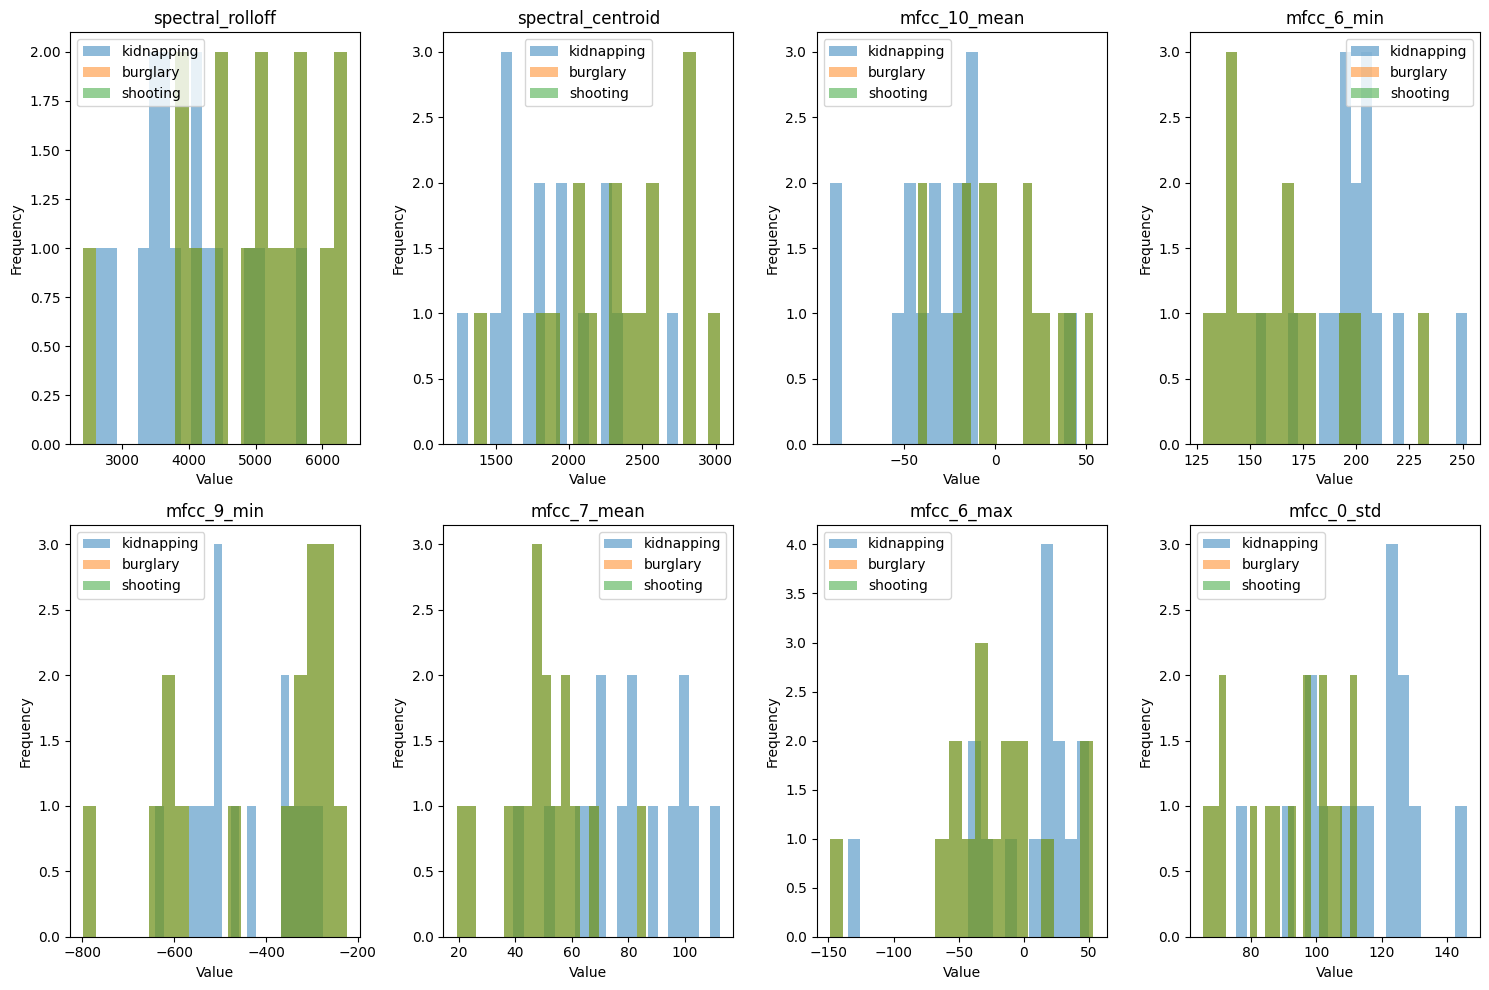

In [7]:
top_features = [feature for feature, _ in sorted_features[:8]]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features):
    plt.subplot(2, 4, i+1)
    for scenario in ['kidnapping', 'burglary', 'shooting']:
        scenario_data = df[df['label'] == scenario][feature]
        plt.hist(scenario_data, alpha=0.5, label=scenario, bins=20)
    plt.title(f'{feature}')
    plt.legend()
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
top_10_features = [feature for feature, _ in sorted_features[:10]]
weight_multiplier = 2.0

X_weighted = X.copy()
for i, feature in enumerate(feature_names):
    if feature in top_10_features:
        X_weighted[:, i] *= weight_multiplier
        print(f"Applied weight {weight_multiplier} to feature: {feature}")


Applied weight 2.0 to feature: mfcc_0_std
Applied weight 2.0 to feature: mfcc_6_max
Applied weight 2.0 to feature: mfcc_6_min
Applied weight 2.0 to feature: mfcc_7_mean
Applied weight 2.0 to feature: mfcc_9_min
Applied weight 2.0 to feature: mfcc_10_mean
Applied weight 2.0 to feature: mfcc_10_min
Applied weight 2.0 to feature: mfcc_11_max
Applied weight 2.0 to feature: spectral_centroid
Applied weight 2.0 to feature: spectral_rolloff


Generating MFCC Spectrograms...


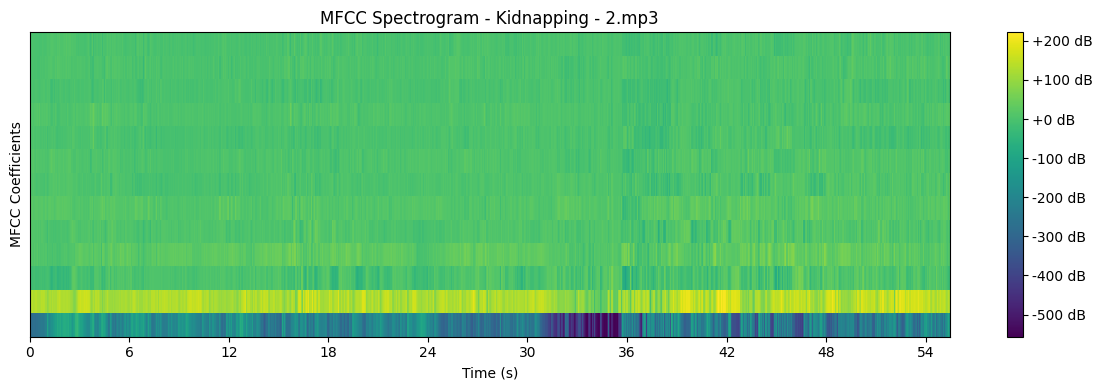

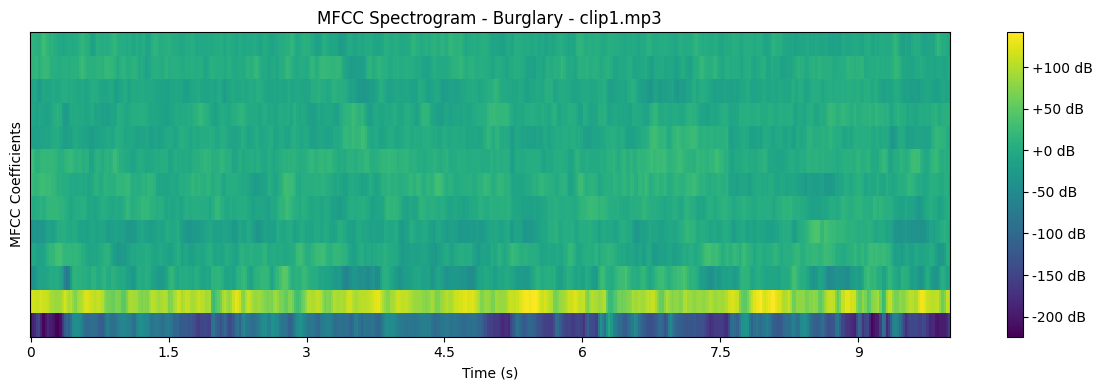

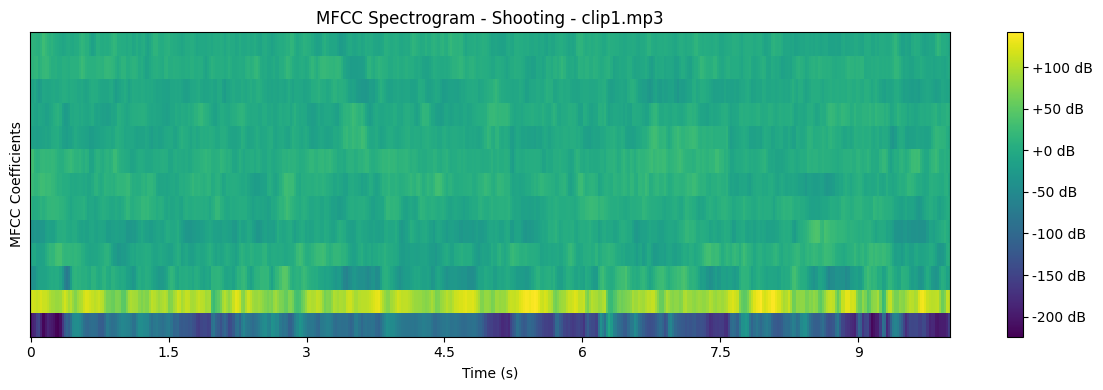

In [10]:
# Generate MFCC Spectrograms for sample files from each scenario
import librosa.display

def plot_mfcc_spectrogram(audio_path, title):
    """Plot MFCC spectrogram for an audio file"""
    y, sr = librosa.load(audio_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC Spectrogram - {title}')
    plt.ylabel('MFCC Coefficients')
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

# Generate spectrograms for first file from each scenario
scenarios = {
    'kidnapping': kidnapping_folder,
    'burglary': burglary_folder,
    'shooting': shooting_folder
}

print("Generating MFCC Spectrograms...")
for scenario, folder_path in scenarios.items():
    files = [f for f in os.listdir(folder_path) if f.endswith(('.mp3', '.wav'))]
    if files:
        sample_file = os.path.join(folder_path, files[0])
        plot_mfcc_spectrogram(sample_file, f"{scenario.title()} - {files[0]}")


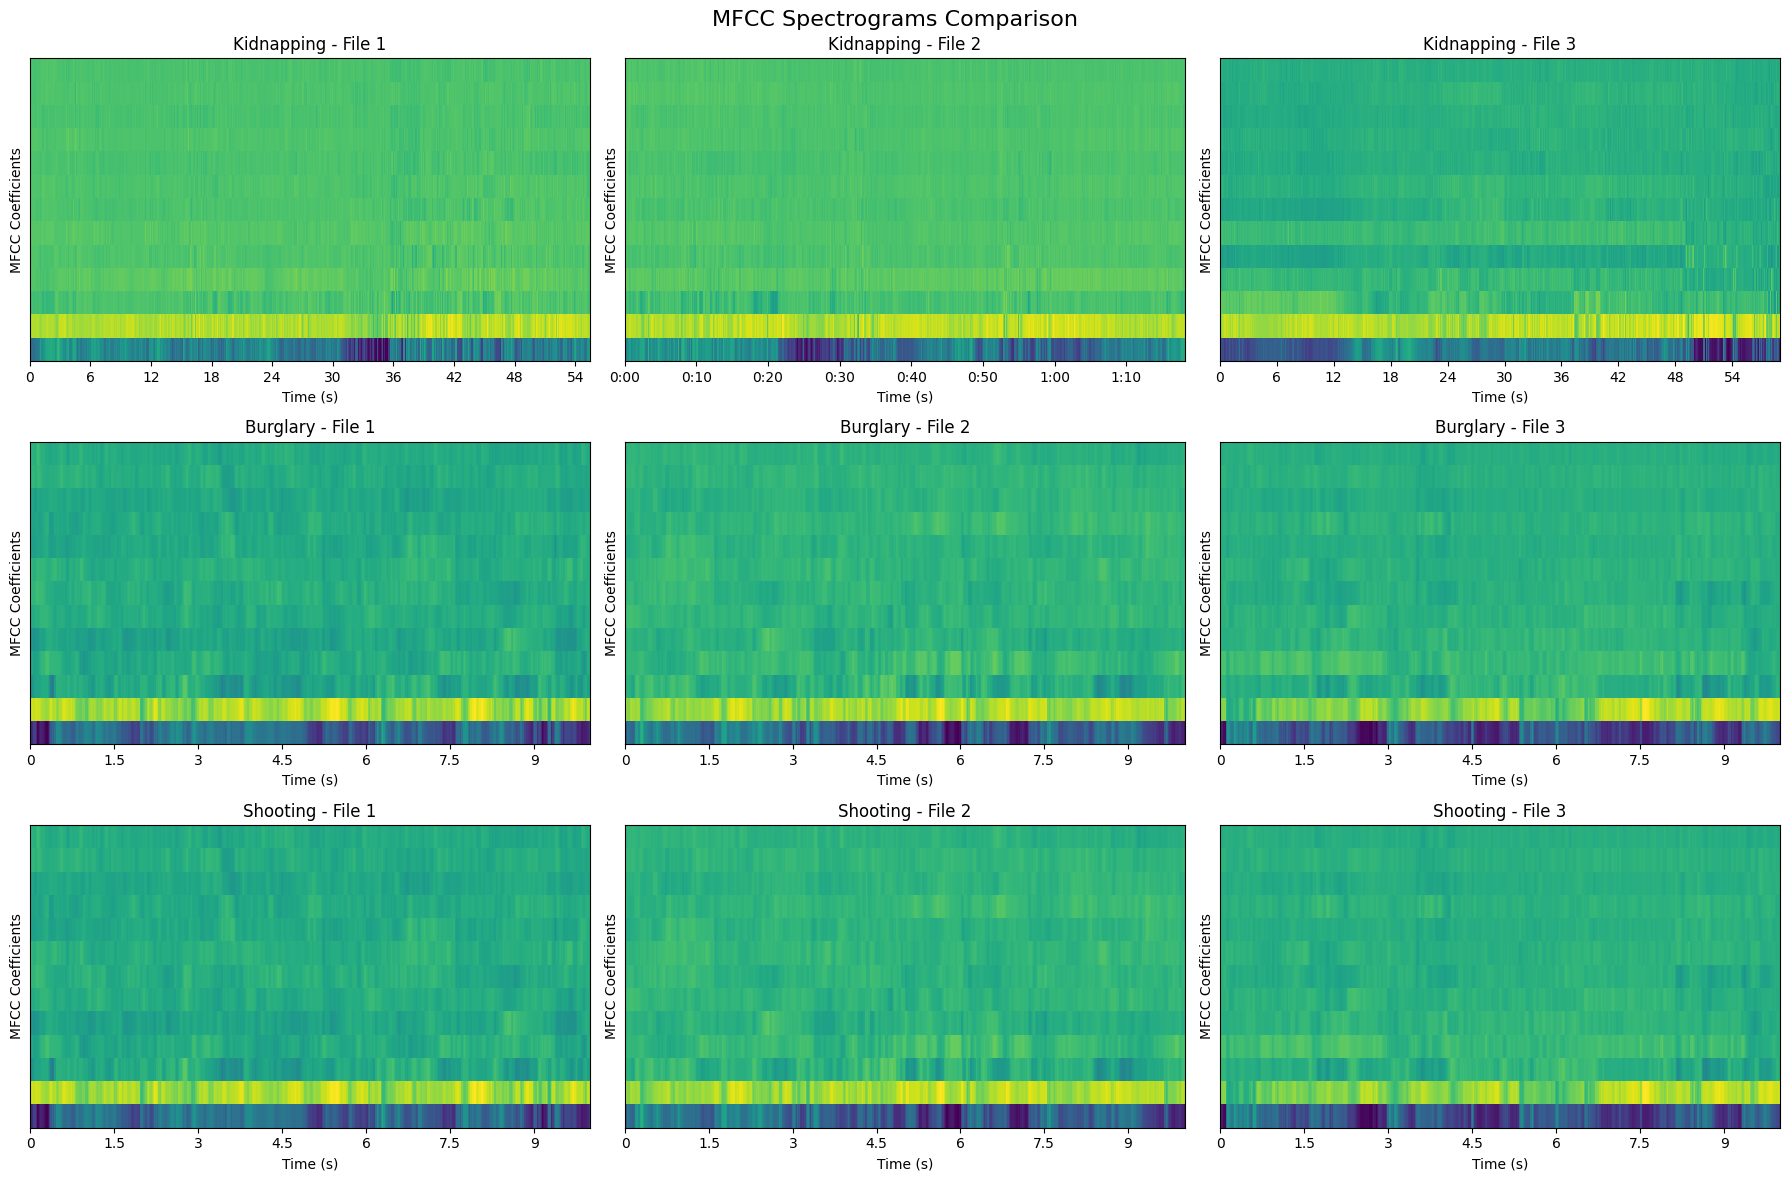

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('MFCC Spectrograms Comparison', fontsize=16)

for row, (scenario, folder_path) in enumerate(scenarios.items()):
    files = [f for f in os.listdir(folder_path) if f.endswith(('.mp3', '.wav'))]
    for col in range(min(3, len(files))):
        audio_path = os.path.join(folder_path, files[col])
        y, sr = librosa.load(audio_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        im = librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='viridis', ax=axes[row, col])
        axes[row, col].set_title(f'{scenario.title()} - File {col+1}')
        axes[row, col].set_ylabel('MFCC Coefficients')
        axes[row, col].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

In [ ]:
import os
import librosa.display

# Create output folders
output_base = '/content/drive/MyDrive/spectrograms'
spectrogram_folders = {
    'kidnapping': os.path.join(output_base, 'kidnapping_spectrograms'),
    'burglary': os.path.join(output_base, 'burglary_spectrograms'),
    'shooting': os.path.join(output_base, 'shooting_spectrograms')
}

# Create directories if they don't exist
for folder in spectrogram_folders.values():
    os.makedirs(folder, exist_ok=True)
    print(f"Created folder: {folder}")

def save_mfcc_spectrogram(audio_path, output_path, filename):
    """Generate and save MFCC spectrogram"""
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # Create spectrogram
        plt.figure(figsize=(12, 8))
        librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'MFCC Spectrogram - {filename}', fontsize=14)
        plt.ylabel('MFCC Coefficients', fontsize=12)
        plt.xlabel('Time (s)', fontsize=12)

        # Save the plot
        output_file = os.path.join(output_path, f"{os.path.splitext(filename)[0]}_spectrogram.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close()  # Close to free memory

        return True
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return False


In [ ]:
scenarios = {
    'kidnapping': kidnapping_folder,
    'burglary': burglary_folder,
    'shooting': shooting_folder
}

total_files = 0
successful_saves = 0

for scenario, input_folder in scenarios.items():
    print(f"\nProcessing {scenario} files...")
    output_folder = spectrogram_folders[scenario]

    # Get all audio files
    audio_files = [f for f in os.listdir(input_folder) if f.endswith(('.mp3', '.wav', '.m4a'))]
    print(f"Found {len(audio_files)} audio files in {scenario} folder")

    for i, filename in enumerate(audio_files):
        audio_path = os.path.join(input_folder, filename)

        print(f"Processing {i+1}/{len(audio_files)}: {filename}")

        if save_mfcc_spectrogram(audio_path, output_folder, filename):
            successful_saves += 1

        total_files += 1

        # Progress indicator
        if (i + 1) % 5 == 0:
            print(f"Completed {i+1}/{len(audio_files)} files for {scenario}")


In [ ]:
print(f"\n Processing complete!")
print(f"Total files processed: {total_files}")
print(f"Successful saves: {successful_saves}")
print(f"Failed saves: {total_files - successful_saves}")

# List saved files in each folder
print("\n Saved spectrograms:")
for scenario, folder in spectrogram_folders.items():
    saved_files = [f for f in os.listdir(folder) if f.endswith('.png')]
    print(f"{scenario.title()}: {len(saved_files)} spectrograms saved in {folder}")

# Optional: Create a summary image showing sample spectrograms
print("\nCreating summary comparison image...")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Sample MFCC Spectrograms by Scenario', fontsize=16)

for i, (scenario, input_folder) in enumerate(scenarios.items()):
    audio_files = [f for f in os.listdir(input_folder) if f.endswith(('.mp3', '.wav', '.m4a'))]
    if audio_files:
        # Use first file as sample
        sample_file = os.path.join(input_folder, audio_files[0])
        y, sr = librosa.load(sample_file, sr=22050)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='viridis', ax=axes[i])
        axes[i].set_title(f'{scenario.title()}\n{audio_files[0]}', fontsize=12)
        axes[i].set_ylabel('MFCC Coefficients')
        axes[i].set_xlabel('Time (s)')


In [ ]:
summary_path = os.path.join(output_base, 'summary_comparison.png')
plt.savefig(summary_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Summary comparison saved to: {summary_path}")

print(f"\n🎉 All spectrograms saved successfully!")
print(f"Check your Google Drive at: {output_base}")